## This is a demonstration of FlexDataset usage

First and foremost, we download the dataset we want to federate in this case MNIST

In [22]:
from tensorflow.keras.datasets import mnist

(train_X, train_y), (test_X, test_y) = mnist.load_data()

Show some samples

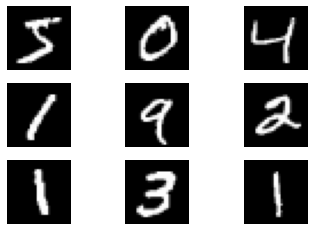

In [23]:
from matplotlib import pyplot as plt

for i in range(9):  
    plt.subplot(330 + 1 + i)
    plt.axis('off') 
    plt.imshow(train_X[i], cmap=plt.get_cmap('gray'))
plt.show()

We encapsulate the chosen dataset in a `FlexDataObject`

In [24]:
from flex.data import FlexDataObject

train_dataset = FlexDataObject(X_data=train_X, y_data=train_y)
test_dataset = FlexDataObject(X_data=test_X, y_data=test_y)

Now, we create a configuration, `FlexDatasetConfig` to federate our dataset, especifically:

    - We want to split the dataset between 10 clients.
    - Each client will have only one class.
    - Each client has only 20% of its assigned class.
    - Clients do not share classes between them.

In [25]:
from flex.data import FlexDatasetConfig
import numpy as np

config = FlexDatasetConfig(seed = 0) # We fix a seed to make our federation reproducible
config.n_clients = 10 # 10 clients
config.replacement = False # ensure that clients do not share any data
config.classes_per_client = np.unique(train_y) # assign each client one class
config.weights = [0.2] * config.n_clients # each client has only 20% of its assigned class

We apply the generated `FlexDatasetConfig` to a `FlexDataObject`, which encapsulates the centralized dataset.

In [26]:
from flex.data import FlexDataDistribution

federated_dataset = FlexDataDistribution.from_config(cdata=train_dataset, config=config)

Show the federated data

Client 0 has class [0] and 1184 elements, a sample of them is:


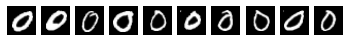

Client 1 has class [1] and 1348 elements, a sample of them is:


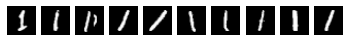

Client 2 has class [2] and 1191 elements, a sample of them is:


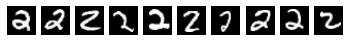

Client 3 has class [3] and 1226 elements, a sample of them is:


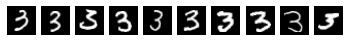

Client 4 has class [4] and 1168 elements, a sample of them is:


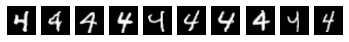

Client 5 has class [5] and 1084 elements, a sample of them is:


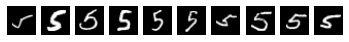

Client 6 has class [6] and 1183 elements, a sample of them is:


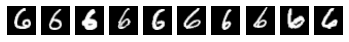

Client 7 has class [7] and 1253 elements, a sample of them is:


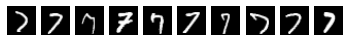

Client 8 has class [8] and 1170 elements, a sample of them is:


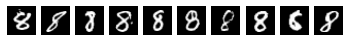

Client 9 has class [9] and 1189 elements, a sample of them is:


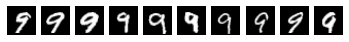

In [27]:
for client in federated_dataset:
    print(f"Client {client} has class {np.unique(federated_dataset[client].y_data)} and {len(federated_dataset[client])} elements, a sample of them is:")
    #pyplot.figure(figsize = (1,10))
    fig, ax = plt.subplots(1, 10) # rows, cols
    for i ,(x, y) in enumerate(federated_dataset[client]):
        ax[i].axis('off')
        ax[i].imshow(x, cmap=plt.get_cmap('gray'))
        if i >= 9:
            break
    plt.show()

Now, we try a more special configuration, we want to federate the dataset such that the number of data per client follows a gaussian distribution:

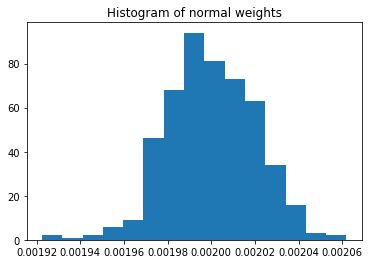

In [28]:
n_clients = 500
mu, sigma = 100, 1  # mean and standard deviation
normal_weights = np.random.default_rng(seed=0).normal(mu, sigma, n_clients)  # sample random numbers
normal_weights = np.clip(normal_weights, a_min=0, a_max=np.inf)  # remove negative values
normal_weights = normal_weights / sum(normal_weights) # normalize to sum 1

plt.hist(normal_weights, bins=15)
plt.title('Histogram of normal weights')
plt.show()

In [29]:
config = FlexDatasetConfig(seed=0, 
                            n_clients=n_clients,
                            replacement=False,
                            weights=normal_weights
                        )

normal_federated_dataset = FlexDataDistribution.from_config(cdata=train_dataset, config=config)

Plot histogram of data per client:

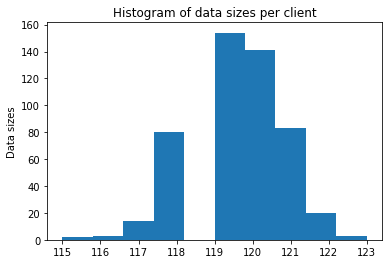

In [30]:
datasizes_per_client = [len(normal_federated_dataset[client]) for client in normal_federated_dataset]
n, bins, patches = plt.hist(datasizes_per_client)
plt.ylabel('Data sizes')
plt.title('Histogram of data sizes per client')
plt.show()

If we want, we can normalize the dataset of each client easily, using the `map` function from `FlexDataset`, for example we force each client to keep only pair labels:

Client 0 has classes [0 2 4 6 8] and 57 elements, a sample of them is:


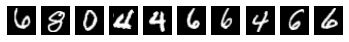

Client 1 has classes [0 2 4 6 8] and 57 elements, a sample of them is:


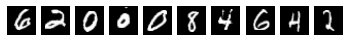

Client 2 has classes [0 2 4 6 8] and 53 elements, a sample of them is:


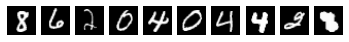

Client 3 has classes [0 2 4 6 8] and 56 elements, a sample of them is:


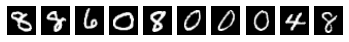

Client 4 has classes [0 2 4 6 8] and 49 elements, a sample of them is:


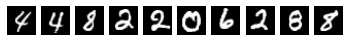

Client 5 has classes [0 2 4 6 8] and 58 elements, a sample of them is:


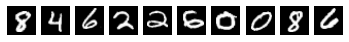

Client 6 has classes [0 2 4 6 8] and 66 elements, a sample of them is:


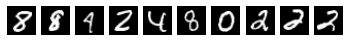

Client 7 has classes [0 2 4 6 8] and 63 elements, a sample of them is:


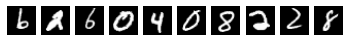

Client 8 has classes [0 2 4 6 8] and 61 elements, a sample of them is:


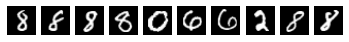

Client 9 has classes [0 2 4 6 8] and 65 elements, a sample of them is:


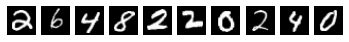

Client 10 has classes [0 2 4 6 8] and 62 elements, a sample of them is:


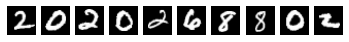

In [31]:
import numpy as np

rng = np.random.default_rng(seed=0)
def keep_given_labels(client_dataset: FlexDataObject, selected_labels): # haz aquí otra operación que se te ocurra raruna
    client_dataset.X_data = client_dataset.X_data[np.isin(client_dataset.y_data, selected_labels)]
    client_dataset.y_data = client_dataset.y_data[np.isin(client_dataset.y_data, selected_labels)]
    return client_dataset

randomly_transformed_federated_dataset = normal_federated_dataset.map(None,  # Apply to all clients
                                                8,  # number of parallel processes 
                                                keep_given_labels,  # function to apply 
                                                [0, 2, 4, 6, 8] # argument for function
                                                )

for client in randomly_transformed_federated_dataset:
    print(f"Client {client} has classes {np.unique(randomly_transformed_federated_dataset[client].y_data)} and {len(randomly_transformed_federated_dataset[client])} elements, a sample of them is:")
    #pyplot.figure(figsize = (1,10))
    fig, ax = plt.subplots(1, 10) # rows, cols
    for i ,(x, y) in enumerate(randomly_transformed_federated_dataset[client]):
        ax[i].axis('off')
        ax[i].imshow(x, cmap=plt.get_cmap('gray'))
        if i >= 9:
            break
    if client >= 10:
        break
    plt.show()